<a href="https://colab.research.google.com/github/MiguelRayan/Ajax/blob/main/TestePetro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


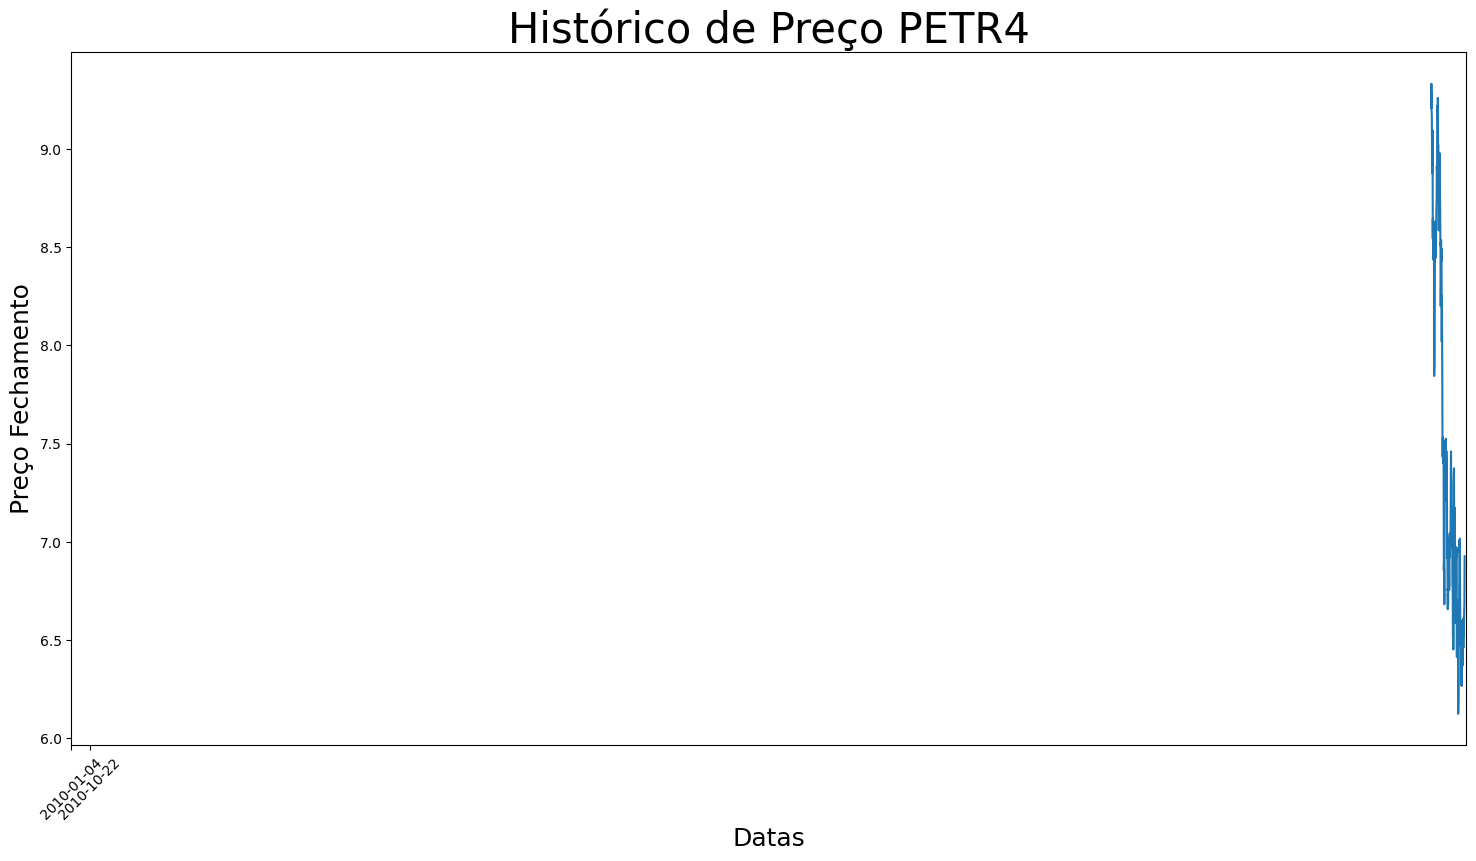

Shapes: X_train: (181, 15, 1), X_val: (10, 15, 1), X_test: (10, 15, 1)
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.1820 - val_loss: 0.0140
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0198 - val_loss: 0.0321
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0195 - val_loss: 0.0135
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0163 - val_loss: 0.0109
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0110 - val_loss: 0.0137
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0090 - val_loss: 0.0076
Epoch 13/30

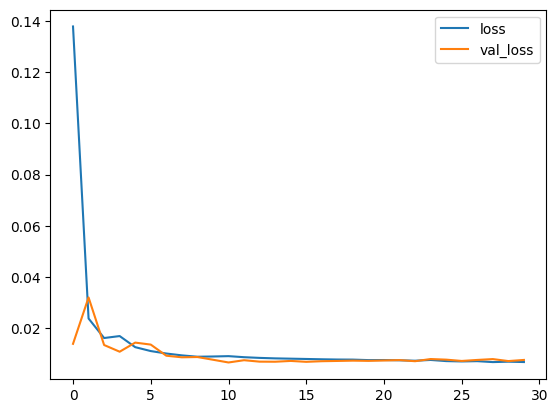

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


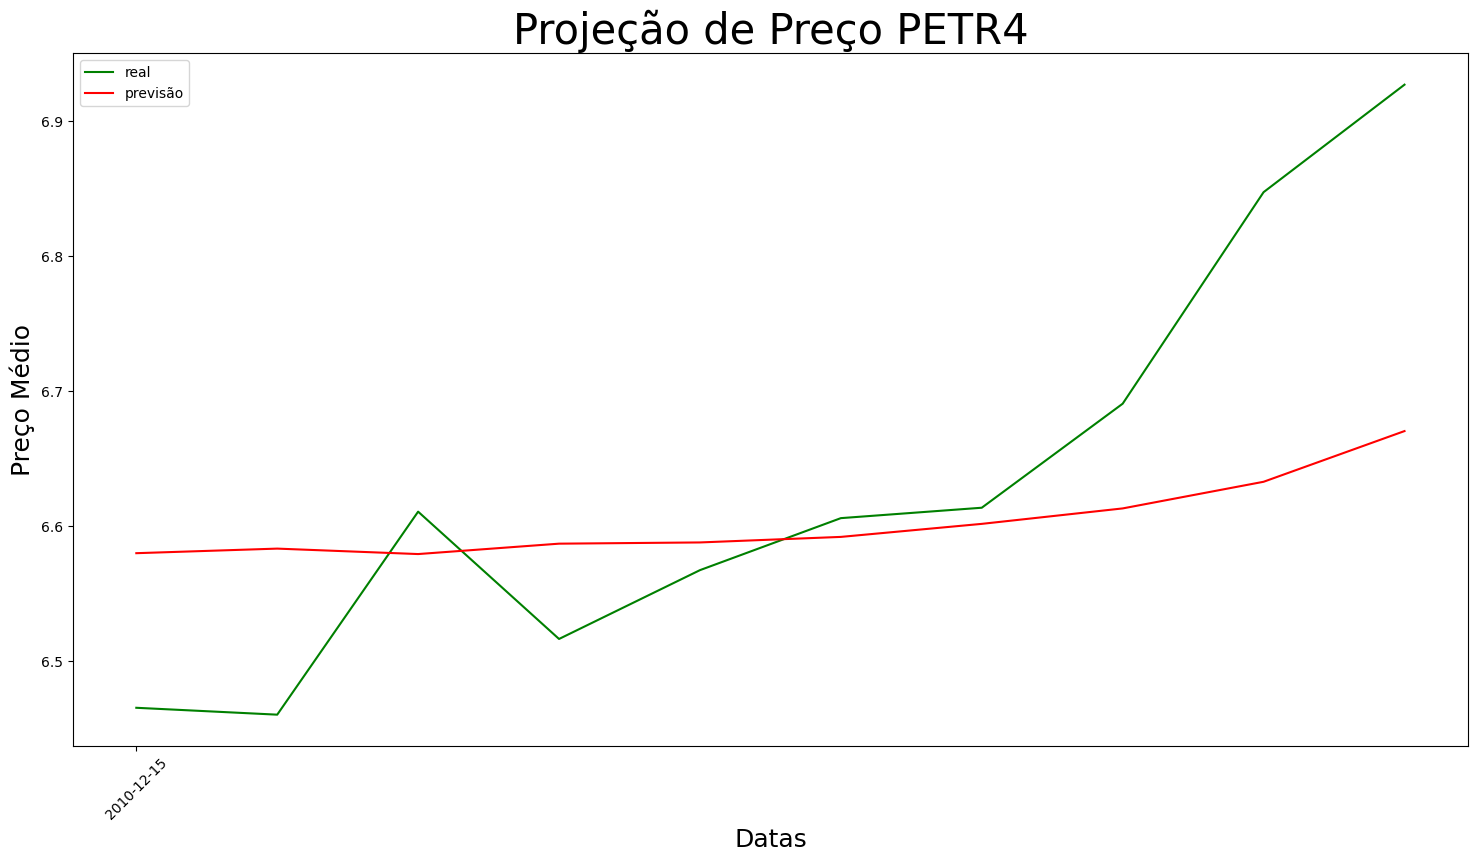

Mean Squared Error: 0.01528198420969602


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

# Baixar dados das ações PETR4 (Petrobras) usando yfinance
df = yf.download('PETR4.SA', start='2010-01-01', end='2010-12-30')
prices = df['Close'].values

# Visualizar o histórico de preços
plt.figure(figsize=(18, 9))
plt.plot(df['Close'])
plt.xticks(range(0, df.shape[0], 200), df.index.strftime('%Y-%m-%d')[::200], rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Fechamento', fontsize=18)
plt.title('Histórico de Preço PETR4', fontsize=30)
plt.show()

# Preparar os dados para a RNN
days_time_step = 15
training_size = int(len(prices) * 0.8)  # Usando 80% dos dados para treino
test_size = len(prices) - training_size
val_size = int(test_size * 0.5)  # Usando 50% dos dados de teste para validação

train_data = np.array(prices[:training_size])
test_data = np.array(prices[training_size:])
val_data = test_data[:val_size]
test_data = test_data[val_size:]

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_norm = scaler.fit_transform(train_data.reshape(-1, 1))  # Ajuste: reshape(-1, 1)
test_data_norm = scaler.transform(test_data.reshape(-1, 1))  # Ajuste: reshape(-1, 1)
val_data_norm = scaler.transform(val_data.reshape(-1, 1))  # Ajuste: reshape(-1, 1)

# Preparação das sequências para LSTM
def prepare_sequences(data_norm, data, days_time_step):
    X, y = [], []
    for i in range(days_time_step, len(data_norm)):
        X.append(data_norm[i-days_time_step:i])
        y.append(data_norm[i])  # Prevendo o valor de fechamento de 1 dia à frente
    return np.array(X), np.array(y)

X_train, y_train = prepare_sequences(train_data_norm, train_data, days_time_step)
X_val, y_val = prepare_sequences(val_data_norm, val_data, days_time_step)
X_test, _ = prepare_sequences(test_data_norm, test_data, days_time_step)

# Verifique se X_val não está vazio antes de fazer o reshape
print(f"Shapes: X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

if X_val.shape[0] > 0:
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
else:
    raise ValueError("X_val está vazio. Verifique a divisão dos dados.")

# Ajuste o formato das entradas para LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(days_time_step, 1)))
model.add(Dense(1))  # Saída para previsão de 1 dia
model.compile(loss='mse', optimizer='adam')

# Treinamento do modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

# Plotar o gráfico de perda durante o treinamento
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Previsão para os próximos 7 dias
predict = model.predict(X_test)
predict = scaler.inverse_transform(predict)
real = test_data[days_time_step:]

# Visualizar as previsões
plt.figure(figsize=(18, 9))
plt.plot(real, color='green', label='real')
plt.plot(predict, color='red', label='previsão')
plt.xticks(range(0, len(real), 50), df.index[-len(real)::50].strftime('%Y-%m-%d'), rotation=45)
plt.xlabel('Datas', fontsize=18)
plt.ylabel('Preço Médio', fontsize=18)
plt.title('Projeção de Preço PETR4', fontsize=30)
plt.legend()
plt.show()

# Avaliação do modelo
mse = mean_squared_error(real, predict)
print(f'Mean Squared Error: {mse}')